In [ ]:
from google.colab import files


uploaded = files.upload()

Saving online_retail.csv to online_retail.csv


In [ ]:
import datetime as dt
import numpy as np
import pandas as pd

In [ ]:

file_name = "online_retail.csv"

df = pd.read_csv(file_name, encoding='ISO-8859-1')

print(f"1. Başlangıç Veri Boyutu: {df.shape}")


df.dropna(subset=['CustomerID'], inplace=True)


df = df[~df['InvoiceNo'].astype(str).str.contains('C')]


df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

print(f"2. Temizlik Sonrası Veri Boyutu: {df.shape}")

1. Başlangıç Veri Boyutu: (541909, 8)
2. Temizlik Sonrası Veri Boyutu: (397884, 8)


In [ ]:

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


df['TotalSum'] = df['Quantity'] * df['UnitPrice']

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [ ]:
import datetime as dt

snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'
})

rfm.rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalSum': 'Monetary'
}, inplace=True)

rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,19,73,1757.55
12350.0,310,17,334.40


In [ ]:
from sklearn.preprocessing import StandardScaler

rfm_log = np.log1p(rfm)

scaler=StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_log)

rfm_scaled_df = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)
rfm_scaled_df.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,1.461993,-2.434387,3.706225
12347.0,-2.038734,1.177483,1.411843
12348.0,0.373104,-0.217054,0.716489
12349.0,-0.623086,0.453387,0.698739
12350.0,1.424558,-0.677192,-0.618962


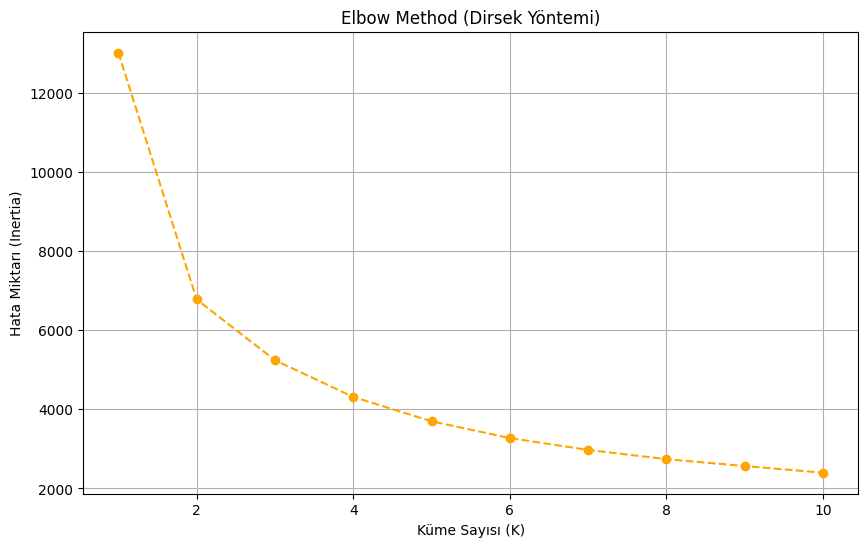

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', color='orange', linestyle='--')
plt.title('Elbow Method (Dirsek Yöntemi)')
plt.xlabel('Küme Sayısı (K)')
plt.ylabel('Hata Miktarı (Inertia)')
plt.grid(True)
plt.show()

In [ ]:

kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)

rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

analiz = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(1)

analiz['Müşteri Sayısı'] = rfm.groupby('Cluster').size()

print("--- Segment Analizi ---")
print(analiz)

--- Segment Analizi ---
         Recency  Frequency  Monetary  Müşteri Sayısı
Cluster                                              
0          185.3       15.0     298.6            1377
1           19.9       38.7     612.1             872
2           13.0      282.9    7042.6             868
3           96.4       80.2    1518.1            1221


In [ ]:
# Örnektir: analiz tablosundaki değerlerine göre 0,1,2,3 yerlerini değiştir
segment_map = {
    0: 'Sıradan Müşteriler',
    1: 'Şampiyonlar',
    2: 'Riskli / Kaybedilenler',
    3: 'Sadık Müşteriler'
}

rfm['Segment'] = rfm['Cluster'].map(segment_map)
rfm.head()

,Recency,Frequency,Monetary,Cluster,Segment
CustomerID,,,,,
12346.0,326,1,77183.60,3,Sadık Müşteriler
12347.0,2,182,4310.00,2,Riskli / Kaybedilenler
12348.0,75,31,1797.24,3,Sadık Müşteriler
12349.0,19,73,1757.55,3,Sadık Müşteriler
12350.0,310,17,334.40,0,Sıradan Müşteriler


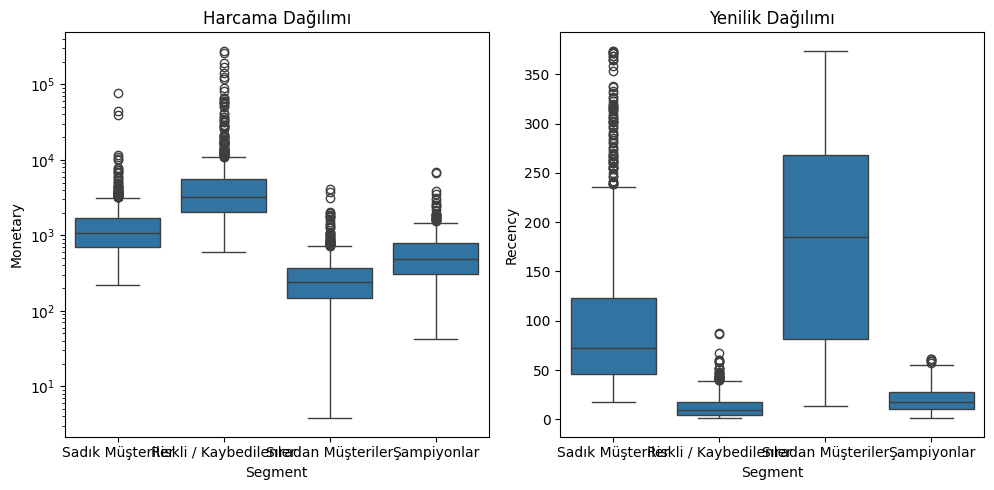

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Monetary dağılımını gruplara göre görelim
plt.subplot(1, 3, 1)
sns.boxplot(x='Segment', y='Monetary', data=rfm)
plt.yscale('log') # Sayılar çok uçuksa logaritmik ölçek iyi olur
plt.title('Harcama Dağılımı')

# Recency dağılımı
plt.subplot(1, 3, 2)
sns.boxplot(x='Segment', y='Recency', data=rfm)
plt.title('Yenilik Dağılımı')

plt.tight_layout()
plt.show()

In [ ]:
import pickle
pickle.dump(kmeans, open('kmeans_model.pkl', 'wb'))
pickle.dump(scaler, open('scaler.pkl', 'wb'))